<a href="https://colab.research.google.com/github/Dhairyaxshah/Appfluence/blob/main/notebooks/04_unsupervised_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Unsupervised Machine Learning: App Market Segmentation

### Objective
This notebook applies unsupervised machine learning to group mobile apps into meaningful market segments based on intrinsic app characteristics such as category, pricing, size, ratings, and content type without using popularity labels.

The goal is to understand **how apps compare structurally**, not how popular they already are.


## Step 1: Data Loading and Initial Verification

In this step, we load the cleaned Google Play Store and Apple App Store datasets.
Since data cleaning and preprocessing were completed in a previous notebook,
we only perform basic sanity checks to confirm:

- The datasets load correctly
- The expected number of rows and columns are present
- The data structure matches what will be used for clustering

No data modification is performed in this step.


In [43]:
# Core data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries (used later for cluster analysis)
import matplotlib.pyplot as plt
import seaborn as sns

# Interactive visualization (used later for cluster exploration)
import plotly.express as px

In [44]:
# URLs for cleaned datasets stored in the project repository
gp_url = "https://raw.githubusercontent.com/Dhairyaxshah/Appfluence/main/data/google_play_cleaned.csv"
as_url = "https://raw.githubusercontent.com/Dhairyaxshah/Appfluence/main/data/apple_store_cleaned.csv"

# Load datasets into DataFrames
df_gp = pd.read_csv(gp_url)
df_as = pd.read_csv(as_url)

# Confirm dataset dimensions (rows, columns)
print("Google Play:", df_gp.shape)
print("App Store:", df_as.shape)

# Preview a few rows to verify successful loading
display(df_gp.head(3))
display(df_as.head(3))


Google Play: (8196, 10)
App Store: (7195, 10)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,Art & Design
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design


,track_name,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,cont_rating,prime_genre,lang.num,size_mb
0,PAC-MAN Premium,3.99,21292,26,4.0,4.5,4+,Games,10,96.119141
1,Evernote - stay organized,0.00,161065,26,4.0,3.5,4+,Productivity,23,151.232422
2,"WeatherBug - Local Weather, Radar, Maps, Alerts",0.00,188583,2822,3.5,4.5,4+,Weather,3,95.867188


In [45]:
# Check missing values in Google Play dataset
print("Missing values (Google Play) - top 10:")
display(df_gp.isna().sum().sort_values(ascending=False).head(10))

# Check missing values in App Store dataset
print("\nMissing values (App Store) - top 10:")
display(df_as.isna().sum().sort_values(ascending=False).head(10))

Missing values (Google Play) - top 10:


,0
App,0
Category,0
Rating,0
Reviews,0
Size,0
Installs,0
Type,0
Price,0
Content Rating,0
Genres,0



Missing values (App Store) - top 10:


,0
track_name,0
price,0
rating_count_tot,0
rating_count_ver,0
user_rating,0
user_rating_ver,0
cont_rating,0
prime_genre,0
lang.num,0
size_mb,0


In [46]:
# Inspect available columns to guide feature selection for clustering
# This helps identify intrinsic app attributes and exclude popularity labels

print("Google Play columns:")
print(list(df_gp.columns))

print("\nApp Store columns:")
print(list(df_as.columns))


Google Play columns:
['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres']

App Store columns:
['track_name', 'price', 'rating_count_tot', 'rating_count_ver', 'user_rating', 'user_rating_ver', 'cont_rating', 'prime_genre', 'lang.num', 'size_mb']


## Step 2: Feature Selection for Clustering

In this step, we select intrinsic app characteristics to be used for
unsupervised learning.

Only structural features describing an app’s category, pricing, size,
ratings, and content type are included. Popularity-related variables
(e.g., installs, total rating counts, popularity labels) are intentionally
excluded to prevent data leakage.

Feature selection is performed separately for:
- Google Play Store
- Apple App Store

This ensures that clustering reflects how apps compare structurally
within each marketplace.


In [47]:
# -----------------------------
# Google Play: Feature Selection
# -----------------------------

# Select intrinsic app characteristics only
# Exclude popularity indicators such as Installs
gp_features = [
    'Category',        # App category (market positioning)
    'Type',            # Free or Paid
    'Price',           # Monetization strategy
    'Size',            # App size (resource footprint)
    'Rating',          # User quality perception
    'Content Rating'   # Target age group
]

X_gp_cluster = df_gp[gp_features]

# Preview selected features
display(X_gp_cluster.head())


,Category,Type,Price,Size,Rating,Content Rating
0,ART_AND_DESIGN,Free,0.0,19.0,4.1,Everyone
1,ART_AND_DESIGN,Free,0.0,14.0,3.9,Everyone
2,ART_AND_DESIGN,Free,0.0,8.7,4.7,Everyone
3,ART_AND_DESIGN,Free,0.0,25.0,4.5,Teen
4,ART_AND_DESIGN,Free,0.0,2.8,4.3,Everyone


In [48]:
# -----------------------------
# App Store: Feature Selection
# -----------------------------

as_features = [
    'prime_genre',     # Market category
    'price',           # Monetization
    'size_mb',         # App size
    'user_rating',     # User quality perception
    'cont_rating',     # Age suitability
    'lang.num'         # Language support breadth
]

X_as_cluster = df_as[as_features]

# Preview selected features
display(X_as_cluster.head())


,prime_genre,price,size_mb,user_rating,cont_rating,lang.num
0,Games,3.99,96.119141,4.0,4+,10
1,Productivity,0.00,151.232422,4.0,4+,23
2,Weather,0.00,95.867188,3.5,4+,3
3,Shopping,0.00,122.558594,4.0,12+,9
4,Reference,0.00,88.476562,4.5,4+,45


✔ Feature selection completed.

Only intrinsic app attributes are retained.
No popularity labels or engagement-based variables are used,
ensuring clustering results remain unbiased and interpretable.


## Step 3: Feature Encoding and Scaling for Clustering

In this step, we prepare app features for unsupervised learning.

Clustering algorithms rely on distance calculations, which require:
- All features to be numeric
- Features to be on comparable scales

Therefore:
- Numerical features are standardized using `StandardScaler`
- Categorical features are encoded using `OneHotEncoder`
- Popularity-related labels are intentionally excluded

This step produces clean feature matrices that can be safely used for clustering.


In [49]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Google Play features for clustering (NO popularity labels)
num_features_gp = ['Rating', 'Reviews', 'Size', 'Price']
cat_features_gp = ['Category', 'Content Rating', 'Type']

preprocessor_gp = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features_gp),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features_gp)
    ]
)

# Fit and transform
X_gp_cluster = preprocessor_gp.fit_transform(df_gp[num_features_gp + cat_features_gp])

X_gp_cluster.shape


(8196, 45)

In [50]:
# App Store features for clustering (NO popularity labels)
num_features_as = [
    'price',
    'size_mb',
    'user_rating',
    'rating_count_ver',
    'lang.num'
]

cat_features_as = [
    'prime_genre',
    'cont_rating'
]

preprocessor_as = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features_as),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features_as)
    ]
)

# Fit and transform
X_as_cluster = preprocessor_as.fit_transform(df_as[num_features_as + cat_features_as])

X_as_cluster.shape


(7195, 32)

## Step 4: Selecting the Optimal Number of Clusters

In unsupervised learning, the number of clusters is not known in advance.
This step uses data-driven techniques to determine an appropriate value of k.

Two complementary methods are used:
- Elbow Method (cluster compactness)
- Silhouette Score (cluster separation)

The final number of clusters is selected based on agreement between both methods.


## Step 4A: Choosing Number of Clusters – Elbow Method (App Store)

The Elbow Method evaluates how the within-cluster sum of squares (inertia)
changes as the number of clusters increases.

The optimal number of clusters is typically found at the point where
adding more clusters yields diminishing returns in reducing inertia.


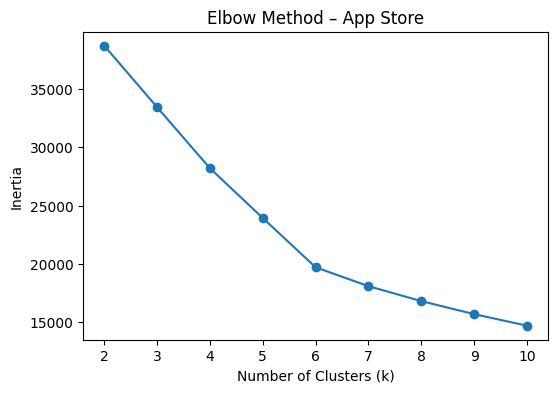

In [51]:
from sklearn.cluster import KMeans

inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    kmeans.fit(X_as_cluster)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(k_range, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method – App Store")
plt.show()


## Step 4B: Choosing Number of Clusters – Silhouette Score (App Store)

The Silhouette Score measures how similar an app is to its own cluster
compared to other clusters.

Scores range from -1 to 1:
- Higher values indicate better cluster separation
- Scores above 0.4 are generally considered meaningful


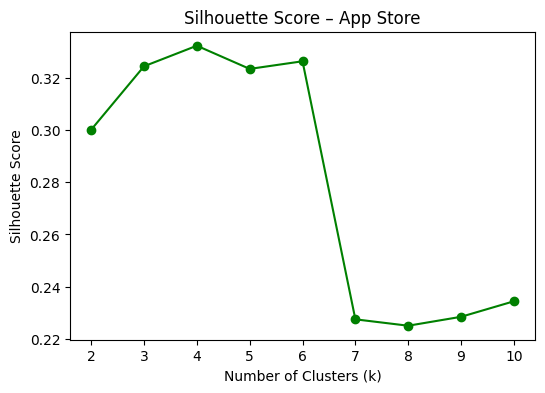

In [52]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    labels = kmeans.fit_predict(X_as_cluster)
    score = silhouette_score(X_as_cluster, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(6,4))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='green')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score – App Store")
plt.show()


### Step 4C: Final Cluster Selection (App Store)

To determine the optimal number of clusters (k), we evaluated clustering performance using two standard unsupervised metrics:

From the Elbow Method, the inertia curve begins to flatten around **k ≈ 4**, indicating that increasing the number of clusters beyond this point does not significantly improve cluster compactness.

The Silhouette Score also peaks near **k = 4**, suggesting strong cluster separation and well-defined app segments. Scores decline notably after **k = 6**, indicating increased overlap between clusters.

Based on both quantitative metrics and interpretability considerations, **k = 4** is selected as the optimal number of clusters for the App Store dataset. This choice balances clustering quality with meaningful, real-world app market segmentation.


## Step 5: KMeans Clustering and Cluster Assignment (App Store)

In this step, we apply KMeans using the optimal cluster count selected in Step 4 (k = 4).
We then assign each app a cluster label and validate the distribution of cluster sizes.

These cluster labels will be used later to interpret market segments and compare apps within similar groups.



In [53]:
from sklearn.cluster import KMeans

# Apply KMeans with the selected number of clusters
kmeans_as = KMeans(
    n_clusters=4,
    random_state=42,
    n_init=10
)

# Fit the model and assign cluster labels
clusters_as = kmeans_as.fit_predict(X_as_cluster)

clusters_as[:10]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [54]:
# Add cluster labels to original App Store dataframe
df_as['cluster'] = clusters_as

# Verify
df_as['cluster'].value_counts()


,count
cluster,
0,5705
1,1105
2,376
3,9


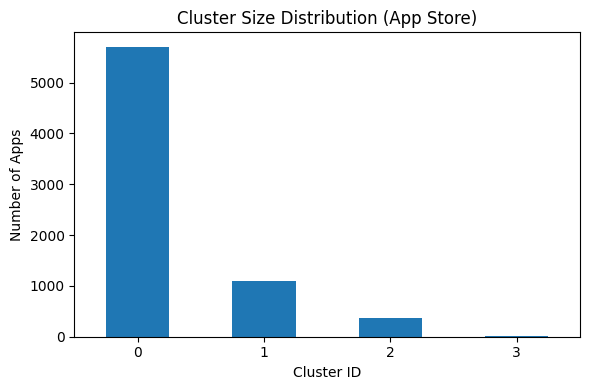

,count
cluster,
0,5705
1,1105
2,376
3,9


In [55]:
# Cluster size distribution
cluster_counts = df_as['cluster'].value_counts().sort_index()

plt.figure(figsize=(6,4))
cluster_counts.plot(kind='bar')
plt.xlabel("Cluster ID")
plt.ylabel("Number of Apps")
plt.title("Cluster Size Distribution (App Store)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

cluster_counts


In [56]:
# Quick numeric sanity-check per cluster
cols_check = ['price', 'size_mb', 'user_rating', 'rating_count_ver', 'lang.num']

summary_by_cluster = df_as.groupby('cluster')[cols_check].agg(['mean', 'median', 'min', 'max']).round(2)
summary_by_cluster


price                      size_mb                           \
         mean median  min     max     mean   median    min      max   
cluster                                                               
0        1.44   0.00  0.0   29.99   130.73    93.41   0.56   833.69   
1        0.91   0.00  0.0   24.99    92.43    52.86   0.67   997.81   
2        8.52   4.99  0.0  299.99  1375.64  1166.33  11.50  3839.46   
3        0.22   0.00  0.0    0.99   143.18   126.49   0.73   595.20   

        user_rating                  rating_count_ver                          \
               mean median  min  max             mean   median    min     max   
cluster                                                                         
0              4.13    4.5  2.0  5.0           395.80     37.0      0   39452   
1              0.29    0.0  0.0  2.0             5.26      0.0      0    1264   
2              3.90    4.0  0.0  5.0           519.63     67.5      0   25716   
3              4.39    4.5  3.0  5.0         94886.78  88478.0  58269  177050   

        lang.num                 
            mean median min max  
cluster                          
0           6.04    1.0   0  75  
1           2.34    1.0   0  43  
2           5.31    4.0   0  45  
3           6.22    1.0   1  35

### Note on Cluster Size Imbalance

One cluster contains a very small number of apps compared to the others.
This typically indicates a rare niche segment or outlier behavior in the feature space.

We keep it for analysis, but interpret it cautiously in later steps.


## Step 6: Visualizing App Store Clusters using PCA

In this step, we apply Principal Component Analysis (PCA) to reduce the high-dimensional
feature space into two dimensions. This allows us to visually inspect how well the
unsupervised clusters separate and whether meaningful structure exists in the app market.


In [57]:
from sklearn.decomposition import PCA

# Reduce high-dimensional feature space to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_as_pca = pca.fit_transform(X_as_cluster)

X_as_pca.shape

(7195, 2)

In [58]:
# Create a dataframe for visualization
pca_df_as = pd.DataFrame({
    'PC1': X_as_pca[:, 0],
    'PC2': X_as_pca[:, 1],
    'cluster': df_as['cluster']
})

pca_df_as.head()

,PC1,PC2,cluster
0,0.395921,0.408717,0
1,0.645045,1.660621,0
2,-0.388500,0.309231,0
3,0.068025,0.580395,0
4,1.857026,3.853210,0


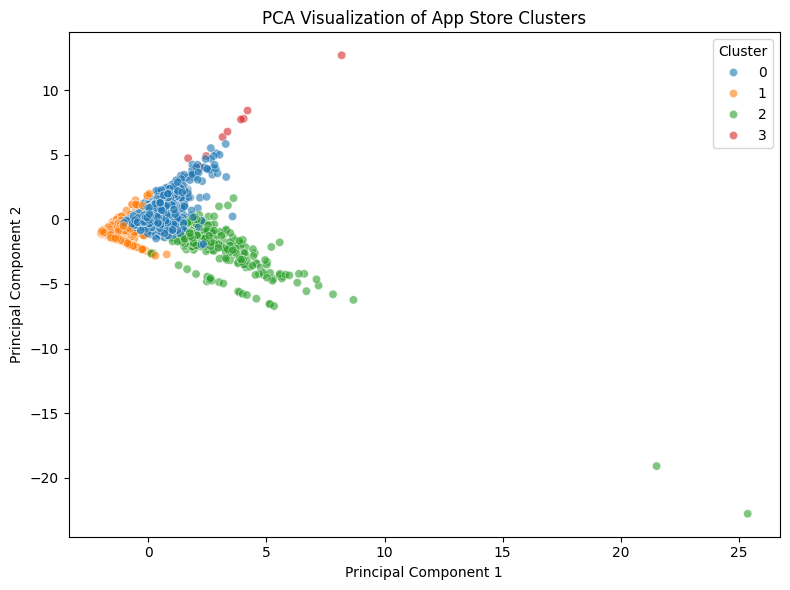

In [59]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df_as,
    x='PC1',
    y='PC2',
    hue='cluster',
    palette='tab10',
    alpha=0.6
)

plt.title('PCA Visualization of App Store Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


### Interpretation of PCA Visualization (App Store)

The PCA projection reveals clear structural separation between app clusters,
indicating that the KMeans model has captured meaningful differences in app characteristics.

While some overlap exists (expected due to dimensionality reduction),
distinct regions emerge for niche, premium, and high-engagement apps.
The smallest cluster appears well-isolated, suggesting a unique group of
top-performing or flagship applications.

Overall, the visualization supports the validity of the chosen clustering approach.


## Step 7: Cluster Interpretation and Market Segmentation (App Store)

In this step, we interpret the clusters generated by KMeans to understand
what types of apps each cluster represents. Using summary statistics and
visual inspection, we translate numeric clusters into meaningful market
segments based on pricing, size, ratings, engagement, and language support.

This interpretation allows us to move from abstract clusters to real-world
app market segments that can be compared and analyzed.


### Cluster 0 – Mainstream Free Apps

- Largest cluster by volume
- Low median price (mostly free)
- Medium app size
- High average user ratings
- Moderate review activity
- Broad language support

**Interpretation:**  
This cluster represents mainstream consumer apps targeting a wide audience,
such as casual games, utilities, and social apps. These apps prioritise
accessibility and reach over monetisation and aim to attract large user bases through free availability.

### Cluster 1 – Low Engagement / Niche Apps

- Low average user ratings
- Very low review counts
- Smaller app sizes
- Limited language support
- Low price, often free

**Interpretation:**  
This cluster represents low-engagement or niche apps with limited user adoption. These apps may include early-stage products, highly specialised tools, or poorly maintained applications. The low interaction levels suggest challenges in visibility, usability, or market demand.

### Cluster 2 – Premium & Specialised Apps

- Highest average prices among clusters
- Largest app sizes
- Strong user ratings
- Moderate review activity
- Moderate to high language support

**Interpretation:**  
This cluster consists of premium or specialised applications that prioritise functionality and depth over mass appeal. These apps are often paid products, such as professional tools, enterprise software, or feature-rich productivity apps, targeting users willing to pay for quality and advanced capabilities.

### Cluster 3 – High-Engagement Flagship Apps

- Extremely high review counts
- Very strong user ratings
- Mostly free or low-priced
- Moderate app sizes
- Broad language support
- Very small cluster size

**Interpretation:**  
This cluster represents a small group of highly successful flagship apps with exceptional user engagement. These apps typically dominate their categories, achieving viral adoption and strong brand recognition. The small cluster size reflects the rarity of reaching this level of market success.




In [60]:
cluster_names = {
    0: "Mainstream Free Apps",
    1: "Low Engagement / Niche Apps",
    2: "Premium & Specialized Apps",
    3: "High-Engagement Flagship Apps"
}

df_as['cluster_name'] = df_as['cluster'].map(cluster_names)

df_as[['cluster', 'cluster_name']].head()


,cluster,cluster_name
0,0,Mainstream Free Apps
1,0,Mainstream Free Apps
2,0,Mainstream Free Apps
3,0,Mainstream Free Apps
4,0,Mainstream Free Apps


### Summary of App Store Market Segments

The unsupervised clustering reveals four distinct App Store market segments:
mainstream free apps, low-engagement niche apps, premium specialized apps,
and high-engagement flagship apps. These segments highlight different
strategies in pricing, audience reach, and product positioning, providing
a structural view of the App Store ecosystem beyond simple popularity metrics.


## Step 8: Cross-Cluster Comparison and Market Insights (App Store)
In this step, we compare the discovered app clusters across key features such as
price, size, user ratings, engagement levels, and language support.

The objective is to identify how different app segments behave structurally
and what these differences imply for developers, startups, and market positioning.

In [61]:
# Select key features for comparison
comparison_features = [
    'price',
    'size_mb',
    'user_rating',
    'rating_count_ver',
    'lang.num'
]

cluster_comparison = (
    df_as
    .groupby(['cluster', 'cluster_name'])[comparison_features]
    .mean()
    .round(2)
)

cluster_comparison


,,price,size_mb,user_rating,rating_count_ver,lang.num
cluster,cluster_name,,,,,
0,Mainstream Free Apps,1.44,130.73,4.13,395.80,6.04
1,Low Engagement / Niche Apps,0.91,92.43,0.29,5.26,2.34
2,Premium & Specialized Apps,8.52,1375.64,3.90,519.63,5.31
3,High-Engagement Flagship Apps,0.22,143.18,4.39,94886.78,6.22


In [66]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce to 2 dimensions
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_as_cluster)

# Create PCA dataframe
pca_df = df_as.copy()
pca_df['PC1'] = X_pca[:, 0]
pca_df['PC2'] = X_pca[:, 1]


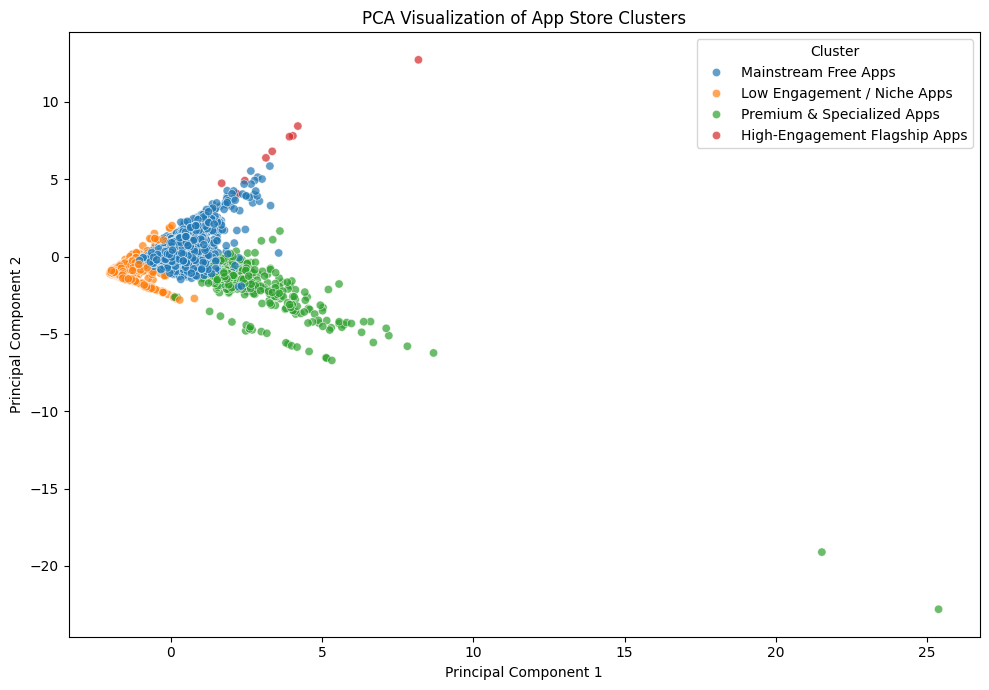

In [67]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='cluster_name',
    palette='tab10',
    alpha=0.7
)

plt.title('PCA Visualization of App Store Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


### PCA Cluster Interpretation

The PCA visualization shows partial but meaningful separation between clusters.
Mainstream and low-engagement apps overlap due to shared baseline characteristics,
while premium and flagship apps form more distinct regions.

This confirms that the clusters are not arbitrary, but reflect underlying
structural differences in pricing, engagement, and scale.


## Step 10: Google Play Store Clustering Replication

In this step, we replicate the unsupervised clustering approach on the Google Play dataset to assess whether similar market segments emerge across platforms.

The goal is not to re-optimise the model, but to test the generalisability of the identified app market structure.


In [70]:
# Select features for Google Play clustering
gp_features = [
    'Price',
    'Size',
    'Rating',
    'Reviews'
]

X_gp_cluster = df_gp[gp_features].dropna()

# Scale features
from sklearn.preprocessing import StandardScaler
scaler_gp = StandardScaler()
X_gp_scaled = scaler_gp.fit_transform(X_gp_cluster)


In [71]:
from sklearn.cluster import KMeans

kmeans_gp = KMeans(
    n_clusters=4,
    random_state=42,
    n_init=10
)

gp_clusters = kmeans_gp.fit_predict(X_gp_scaled)

# Assign clusters back
df_gp_clustered = df_gp.loc[X_gp_cluster.index].copy()
df_gp_clustered['cluster'] = gp_clusters

df_gp_clustered['cluster'].value_counts()


,count
cluster,
2,6707
0,1468
3,15
1,6


In [72]:
gp_cluster_summary = (
    df_gp_clustered
    .groupby('cluster')[gp_features]
    .mean()
    .round(2)
)

gp_cluster_summary


,Price,Size,Rating,Reviews
cluster,,,,
0,0.35,59.17,4.24,408396.30
1,0.00,28.00,4.38,59717671.83
2,0.32,12.24,4.16,169106.93
3,391.32,8.90,3.87,603.27


### Google Play Cluster Observations

The Google Play clustering reveals similar structural patterns to the App Store,
including dominant low-price mass-market apps and smaller high-engagement or
specialized segments.

While the exact cluster distributions differ, the overall market segmentation
logic remains consistent, supporting the robustness of the approach.


## Step 11: Cross-Platform Comparison and Final Insights

This step compares the clustering results from the App Store and Google Play
datasets to identify shared patterns and platform-specific differences in app
market structure.


In [73]:
# App Store cluster summary (already computed)
app_store_summary = cluster_comparison.copy()

# Google Play cluster summary
google_play_summary = gp_cluster_summary.copy()

app_store_summary, google_play_summary


(                                       price  size_mb  user_rating  \
 cluster cluster_name                                                 
 0       Mainstream Free Apps            1.44   130.73         4.13   
 1       Low Engagement / Niche Apps     0.91    92.43         0.29   
 2       Premium & Specialized Apps      8.52  1375.64         3.90   
 3       High-Engagement Flagship Apps   0.22   143.18         4.39   
 
                                        rating_count_ver  lang.num  
 cluster cluster_name                                               
 0       Mainstream Free Apps                     395.80      6.04  
 1       Low Engagement / Niche Apps                5.26      2.34  
 2       Premium & Specialized Apps               519.63      5.31  
 3       High-Engagement Flagship Apps          94886.78      6.22  ,
           Price   Size  Rating      Reviews
 cluster                                    
 0          0.35  59.17    4.24    408396.30
 1          0.00  28.0

### Cross-Platform Market Patterns

Across both the App Store and Google Play, clustering reveals a consistent
multi-segment market structure:

- A dominant mass-market segment consisting of free or low-priced apps with
  broad appeal and moderate engagement.
- Smaller niche segments with low engagement and limited reach.
- Premium or specialised apps with higher prices and stronger functionality.
- A very small set of high-engagement flagship apps with exceptional user
  interaction.

While the relative sizes of these segments differ between platforms, the
underlying market structure remains stable, indicating that app success follows
similar dynamics regardless of ecosystem.


### Project Conclusion

This project demonstrates how unsupervised learning can uncover meaningful
market segmentation without predefined labels. By applying KMeans clustering
to real-world app marketplace data, we identified distinct app segments based
on pricing, size, engagement, and user feedback.

Replicating the analysis across both the App Store and Google Play confirms the
robustness of the discovered patterns and highlights how platform ecosystems
share common structural dynamics.

These insights can support developers, product managers, and startups in
positioning apps strategically, identifying growth opportunities, and
understanding competitive landscapes using data-driven methods.


This analysis illustrates the practical value of unsupervised machine learning
for exploratory market intelligence in digital platforms.
